In [1]:
import mne
import csv
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [2]:
names = [
    'Beam',
    'Eye',
    'Fluke',
    'Fong',
    'Joke',
    'Pod',
    'Tau',
    'Toey',
    'Tong',
]

In [3]:
filenames = [
    'Beam-t1 (1024Hz)',
    'Beam-t2 (1024Hz)',
    'Beam-t3 (1024Hz)',
    'Beam-t6 (1024Hz)',
    'Beam-t7 (1024Hz)',
    'Beam-t8 (1024Hz)',
    'Eye-t2 (1024Hz)',
    'Eye-t3 (1024Hz)',
    'Eye-t4 (1024Hz)',
    'Eye-t5 (1024Hz)',
    'Eye-t6 (1024Hz)',
    'Eye-t7 (1024Hz)',
    'Fluke-t20 (1024Hz)',
    'Fluke-t21 (1024Hz)',
    'Fluke-t22 (1024Hz)',
    'Fluke-t23 (1024Hz)',
    'Fluke-t24 (1024Hz)',
    'Fluke-t25 (1024Hz)',
    'Fong-t3 (1024Hz)',
    'Fong-t4 (1024Hz)',
    'Fong-t5 (1024Hz)',
    'Fong-t6 (1024Hz)',
    'Fong-t7 (1024Hz)',
    'Fong-t8 (1024Hz)',
    'Joke-t1 (1024Hz)',
    'Joke-t2 (1024Hz)',
    'Joke-t3 (1024Hz)',
    'Joke-t4 (1024Hz)',
    'Joke-t5 (1024Hz)',
    'Joke-t6 (1024Hz)',
    'Pod-t21 (1024Hz)',
    'Pod-t23 (1024Hz)',
    'Pod-t24 (1024Hz)',
    'Pod-t25 (1024Hz)',
    'Pod-t26 (1024Hz)',
    'Tau-t13 (1024Hz)',
    'Tau-t14 (1024Hz)',
    'Tau-t15 (1024Hz)',
    'Tau-t16 (1024Hz)',
    'Tau-t17 (1024Hz)',
    'Tau-t18 (1024Hz)',
    'Toey-t1 (1024Hz)',
    'Toey-t2 (1024Hz)',
    'Toey-t3 (1024Hz)',
    'Toey-t4 (1024Hz)',
    'Toey-t5 (1024Hz)',
    'Toey-t6 (1024Hz)',
    'Toey-t7 (1024Hz)',
    'Tong-t1 (1024Hz)',
    'Tong-t2 (1024Hz)',
    'Tong-t3 (1024Hz)',
    'Tong-t4 (1024Hz)',
    'Tong-t5 (1024Hz)',
    'Tong-t6 (1024Hz)'
]

In [4]:
def standardize(X):
    return preprocessing.scale(X)

## Importing EEG Data

In [5]:
# Initialize an info structure
n_channel = 19
ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
ch_types = ['eeg'] * n_channel + ['stim']
sfreq = 1024 # Sampling rate 1024 Hz
montage = mne.channels.read_montage('standard_1005', ch_names)
mne_info = mne.create_info(
    ch_names = ch_names + ['event'],
    sfreq = sfreq,
    ch_types = ch_types,
    montage = montage
)
event_id = {'idle': 0, 'onset': 1}
picks = mne.pick_types(mne_info, eeg = True)

In [6]:
subject_name = 'Beam'
data_dir = './data/trim/'

epochs_all = None
for i in range(0, len(filenames)):
    name, _ = filenames[i].split('-')
    if name == subject_name:
        np_raw_data = np.genfromtxt(data_dir + filenames[i] + '_data_label.csv', delimiter = ',')
        # np_raw_data[:, np.arange(0, n_channel, 1)] = standardize(np_raw_data[:, np.arange(0, n_channel, 1)])
        mne_raw_data = mne.io.RawArray(np_raw_data.T, mne_info)
        # Band-pass Filter
        mne_raw_data = mne_raw_data.filter(0.1, 30, picks = picks, method = 'iir')
        events = mne.find_events(mne_raw_data, stim_channel = 'event', output = 'step', consecutive = True)
        epochs = mne.Epochs(mne_raw_data, events, event_id, 0, 2, proj = False,
                            picks = picks, baseline = None, preload = True)
        if epochs_all is None:
            epochs_all = epochs
        else:
            epochs_all = mne.concatenate_epochs([epochs_all, epochs])
print('Done.')

Creating RawArray with float64 data, n_channels=20, n_times=245760
    Range : 0 ... 245759 =      0.000 ...   239.999 secs
Ready.
Setting up band-pass filter from 0.1 - 30 Hz
121 events found
Events id: [0 1 2]
61 matching events found
Loading data for 61 events and 2049 original time points ...
1 bad epochs dropped
Creating RawArray with float64 data, n_channels=20, n_times=192512
    Range : 0 ... 192511 =      0.000 ...   187.999 secs
Ready.
Setting up band-pass filter from 0.1 - 30 Hz
101 events found
Events id: [0 1 2]
51 matching events found
Loading data for 51 events and 2049 original time points ...
1 bad epochs dropped
110 matching events found
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=20, n_times=207872
    Range : 0 ... 207871 =      0.000 ...   202.999 secs
Ready.
Setting up band-pass filter from 0.1 - 30 Hz
113 events found
Events id: [0 1 2]
57 matching events found
Loading data for 57 events and 2049 original time points ...
1 bad epochs drop

In [7]:
# Standard Scale
scaler = mne.decoding.Scaler(scalings = 'mean', with_mean = True, with_std = True)
transformed_epochs_data = scaler.fit_transform(epochs_all.get_data())

In [8]:
# Resample
down_sfreq = 64.
down_factor = sfreq / down_sfreq
transformed_epochs_data = mne.filter.resample(transformed_epochs_data, down = down_factor, npad = 'auto', pad = 'edge')
# transformed_epochs = epochs_all.copy().resample(64)

In [9]:
# Data and Labels
X = transformed_epochs_data
y = epochs_all.events[:, -1]

In [10]:
X.shape

(347, 19, 128)

In [11]:
# Assemble a classifier
lda = LinearDiscriminantAnalysis()

n_freqs = 30
freqs = np.linspace(0.1, 5, n_freqs) # Frequencies of interest
n_cycles = freqs / 2.
tf = mne.decoding.TimeFrequency(freqs, sfreq = down_sfreq, n_cycles = n_cycles, output = 'power')

vectorizer = mne.decoding.Vectorizer()
csp = mne.decoding.CSP(n_components = 19, cov_est = 'epoch', transform_into = 'csp_space', norm_trace = True)

# Use scikit-learn Pipeline with cross_val_score function
# clf = Pipeline([('CSP', csp), ('VEC', vectorizer), ('LDA', lda)])
clf = Pipeline([('TF', tf), ('VEC', vectorizer), ('LDA', lda)])
predicted = cross_val_predict(clf, X, y, cv = 10)

frequencies is deprecated and will be removed in 0.16, usefreqs instead
frequencies is deprecated and will be removed in 0.16, usefreqs instead


/usr/local/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator TimeFrequency modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


frequencies is deprecated and will be removed in 0.16, usefreqs instead
frequencies is deprecated and will be removed in 0.16, usefreqs instead


/usr/local/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator TimeFrequency modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


frequencies is deprecated and will be removed in 0.16, usefreqs instead
frequencies is deprecated and will be removed in 0.16, usefreqs instead


/usr/local/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator TimeFrequency modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


frequencies is deprecated and will be removed in 0.16, usefreqs instead
frequencies is deprecated and will be removed in 0.16, usefreqs instead


/usr/local/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator TimeFrequency modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


frequencies is deprecated and will be removed in 0.16, usefreqs instead
frequencies is deprecated and will be removed in 0.16, usefreqs instead


/usr/local/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator TimeFrequency modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


frequencies is deprecated and will be removed in 0.16, usefreqs instead
frequencies is deprecated and will be removed in 0.16, usefreqs instead


/usr/local/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator TimeFrequency modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


frequencies is deprecated and will be removed in 0.16, usefreqs instead
frequencies is deprecated and will be removed in 0.16, usefreqs instead


/usr/local/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator TimeFrequency modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


frequencies is deprecated and will be removed in 0.16, usefreqs instead
frequencies is deprecated and will be removed in 0.16, usefreqs instead


/usr/local/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator TimeFrequency modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


frequencies is deprecated and will be removed in 0.16, usefreqs instead
frequencies is deprecated and will be removed in 0.16, usefreqs instead


/usr/local/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator TimeFrequency modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


frequencies is deprecated and will be removed in 0.16, usefreqs instead
frequencies is deprecated and will be removed in 0.16, usefreqs instead


/usr/local/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator TimeFrequency modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [12]:
acc = metrics.accuracy_score(y, predicted)
f1 = metrics.f1_score(y, predicted)
tn, fp, fn, tp = metrics.confusion_matrix(y, predicted).ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
print('Acc: {0:.10f}'.format(acc))
print('F1: {0:.10f}'.format(f1))
print('TPR: {0:.10f}'.format(tpr))
print('FPR: {0:.10f}'.format(fpr))

Acc: 0.4985590778
F1: 0.5297297297
TPR: 0.5326086957
FPR: 0.5398773006


In [ ]:
result_filename = 'iir01-30_csp_lda'
with open('./data/classification/result/' + result_filename + '.csv', 'w', newline='') as fout:
    fieldnames = ['Name', 'Acc', 'F1', 'TPR', 'FPR']
    writer = csv.DictWriter(fout, fieldnames = fieldnames)
    writer.writeheader()
    writer.writerow({'Name': names[i],
                        'N': len(np_label_data_1),
                        'Mean': '{:.16f}'.format(stat['1']['mean']),
                        'Med': '{:.16f}'.format(stat['1']['med']),
                        'Std': '{:.16f}'.format(stat['1']['std']),
                        'Min': '{:.16f}'.format(stat['1']['min']),
                        'Max': '{:.16f}'.format(stat['1']['max'])
                    })

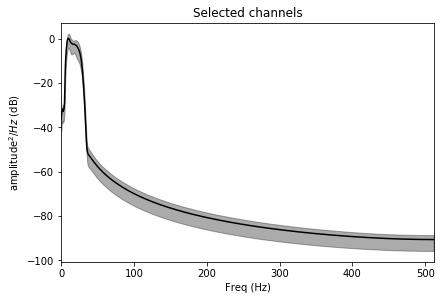

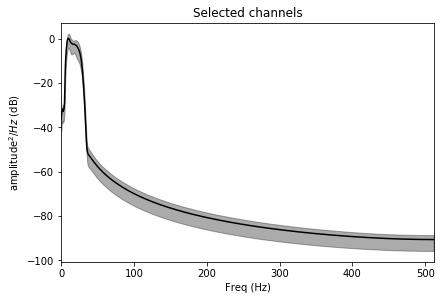

In [48]:
filtered_epochs_all.plot_psd(area_mode = 'range', tmin = 0., tmax = 2., picks = picks)

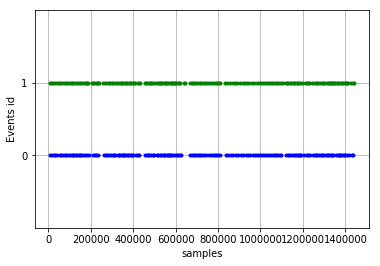

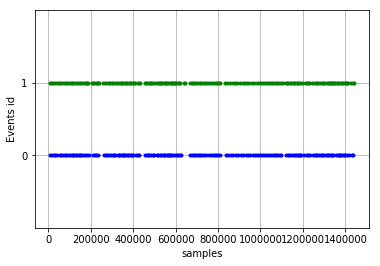

In [83]:
mne.viz.plot_events(epochs_all.events)

347 matching events found
0 projection items activated
0 bad epochs dropped


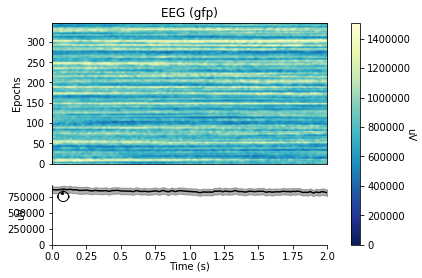

In [82]:
epochs_all.plot_image(combine='gfp', group_by='type', sigma=2., cmap="YlGnBu_r")

In [49]:
# epochs.plot_topo_image(vmin=-250, vmax=250, title='ERP images', sigma=2.)

In [75]:
evoked = epochs_all.average()

In [76]:
evoked.data.shape

(19, 2049)

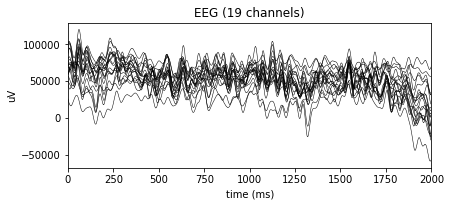

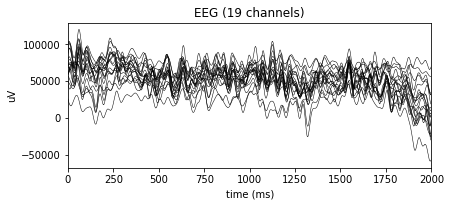

In [77]:
evoked.plot()

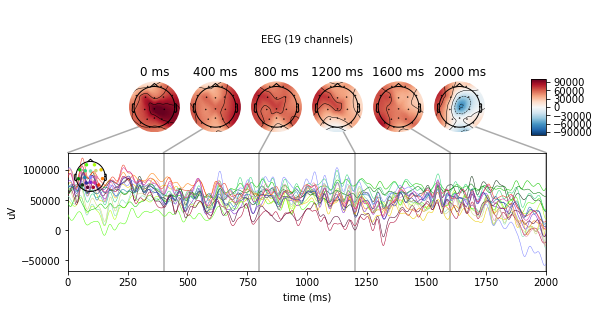

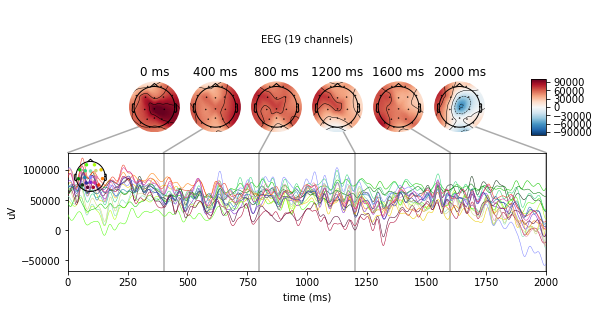

In [78]:
# Event-related Potential (ERP)
# evoked.plot_joint()
evoked.plot_joint(times = np.arange(0, 2.1, 0.4))

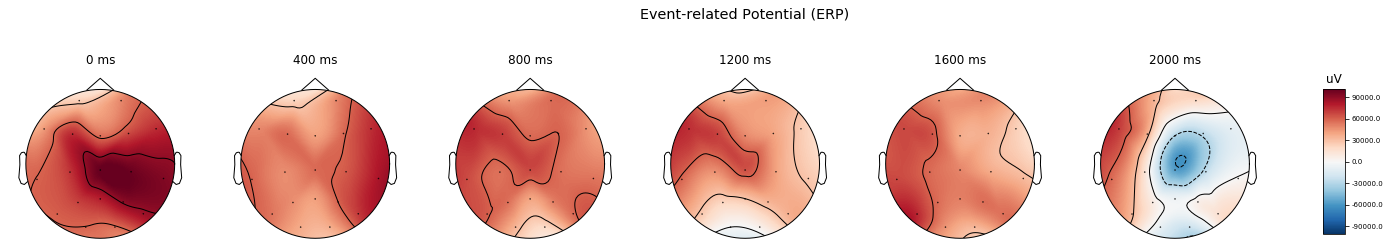

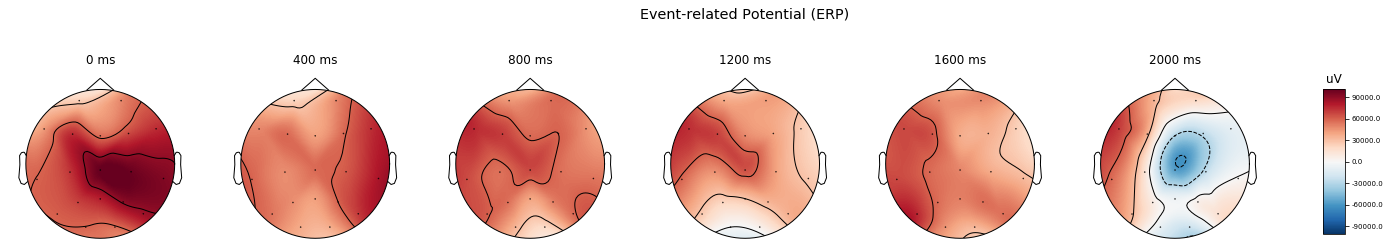

In [79]:
# Event-related Potential (ERP)
# %matplotlib notebook
# %matplotlib inline
title = 'Event-related Potential (ERP)'
# evoked.plot(titles = dict(eeg = title))
evoked.plot_topomap(times = np.arange(0, 2.1, 0.4), size = 2., title = title)

In [80]:
n_cycles = 2  # Number of cycles in Morlet wavelet
freqs = np.arange(30, 71, 1)  # Frequencies of interest

No baseline correction applied


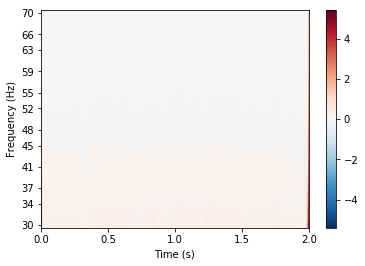

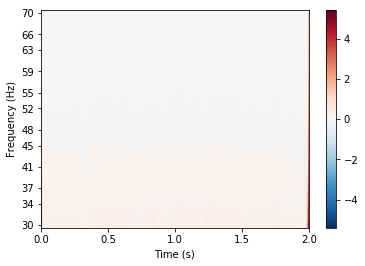

In [81]:
power, itc = mne.time_frequency.tfr_morlet(epochs, freqs = freqs, n_cycles = n_cycles,
                                            return_itc = True, decim = 3, n_jobs = 1)
power.plot([power.ch_names.index('Pz')])

# EEG Electrode Positions

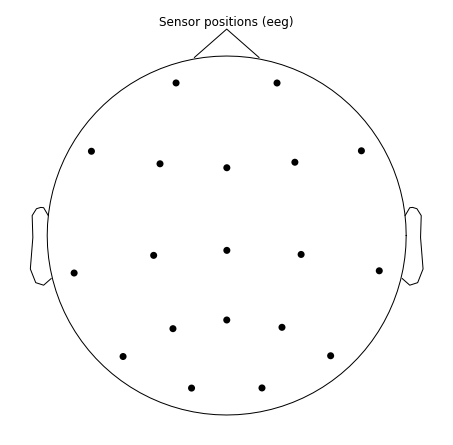

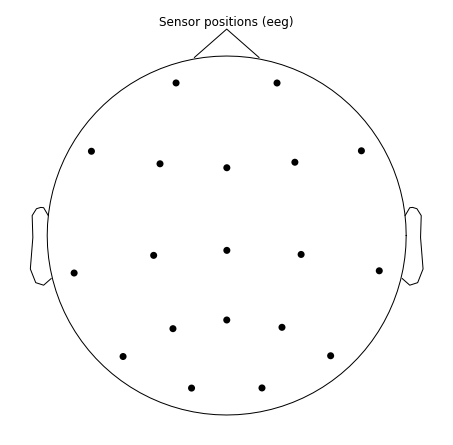

In [44]:
mne_raw_data.plot_sensors()